# Model Creation 3 - showcasing results

## Library and model load

In [2]:
import straw
import math
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
import sklearn 
import networkx as nx
import igraph as ig
from itertools import count
from scipy import ndimage
from scipy.interpolate import interp1d, make_interp_spline, UnivariateSpline
from scipy.signal import find_peaks
from sklearn.decomposition import NMF
from scipy.sparse import csgraph
from scipy.spatial import distance_matrix
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

class Model:
    
    def __init__(self):
        self.data = None
        
    ###########################################################################################

    def read_data(self, paht_to_file, chromosome, resolution, do_smoothing = True):
        
        def get_df(normalisation, file_path, chromosome_1, chromosome_2, length_unit, resolution):
            # Data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525
            # GSE63525_GM12878_diploid_maternal.hic
            df = straw.straw(normalisation, file_path, chromosome_1, chromosome_2, length_unit, resolution) 
            # example values: "KR", "../Data/GSE63525_GM12878_diploid_maternal.hic", "11", "11", "BP", 500000

            # Transforming the list to a data frame with three columns.
            # Origininally the raed data is a list of three lists, 
            # each with the same length (list of x, y and counts).
            df = pd.DataFrame(df).transpose()
            df.columns = ['x', 'y', 'count']

            return df
        
        def is_symmetric(matrix):
            """
            Check if a matrix is symmetric.

            Parameters:
                matrix (list of lists): The input matrix.

            Returns:
                bool: True if the matrix is symmetric, False otherwise.
            """
            n = len(matrix)
            if n != len(matrix[0]):
                return False  # Matrix is not square, so it can't be symmetric

            for i in range(n):
                for j in range(i + 1, n):
                    if matrix[i][j] != matrix[j][i]:
                        return False  # If corresponding elements are not equal, matrix is not symmetric

            return True

        def make_symmetric(matrix):
            """
            Make a matrix symmetric by copying the lower triangle to the upper triangle.

            Parameters:
                matrix (list of lists): The input matrix.

            Returns:
                list of lists: The corrected symmetric matrix.
            """
            n = len(matrix)
            if n != len(matrix[0]):
                raise ValueError("Input matrix is not square")

            for i in range(n):
                for j in range(i + 1, n):
                    matrix[j][i] = matrix[i][j]
                    
            return matrix
                    
        def median_filtering(matrix, size=3):
            """
            Apply median filtering to a sparse matrix.

            Parameters:
                matrix (numpy.ndarray): The input matrix.
                size (int): The size of the median filter kernel.

            Returns:
                numpy.ndarray: The smoothed matrix.
            """
            smoothed_matrix = ndimage.median_filter(matrix, size=size)
            return smoothed_matrix

        def gaussian_smoothing(matrix, sigma=1):
            """
            Apply Gaussian smoothing to a sparse matrix.

            Parameters:
                matrix (numpy.ndarray): The input matrix.
                sigma (float): Standard deviation of the Gaussian filter.

            Returns:
                numpy.ndarray: The smoothed matrix.
            """
            smoothed_matrix = ndimage.gaussian_filter(matrix, sigma=sigma)
            return smoothed_matrix

        def mean_smoothing(matrix, size=1):
            """
            Apply Mean smoothing to a sparse matrix.

            Parameters:
                matrix (numpy.ndarray): The input matrix.
                sigma (float): Standard deviation of the Gaussian filter.

            Returns:
                numpy.ndarray: The smoothed matrix.
            """
            smoothed_matrix = ndimage.uniform_filter(matrix, size)
            return smoothed_matrix

            return matrix
        
        def general_information_about_data(df):
            print(f'Number of rows: {len(df)}')
            print(f"Number of unique x and y values: {df['x'].nunique()}, {df['y'].nunique()}")
            print(f"Mean interactions per fragment {df['count'].mean()}")
            print(f"Median of interactions per fragment {df['count'].median()}")
        
        df = get_df("KR", paht_to_file, chromosome, chromosome, "BP", resolution)
        general_information_about_data(df)
        data = np.nan_to_num(df.pivot(index='x', columns='y', values='count').to_numpy(),
                           copy=True, nan=0.0, posinf=None, neginf=None)
        
        if not is_symmetric(data):
            data = make_symmetric(data)
            
        data = data + data.T - np.diag(data.diagonal())
        
        # Selected best parameters based on testing:
        smoothing = 3
        smoothing_param = math.floor(len(data)/100)
        
        if do_smoothing:
        
            if smoothing == 1:
                data = median_filtering(data, smoothing_param)
            elif smoothing == 2:
                data = gaussian_smoothing(data, smoothing_param)
            elif smoothing == 3:
                data = mean_smoothing(data, smoothing_param)
            else:
                print('Selected no smoothing. To select:\n\
                        median_filtering - type 1\n\
                        gaussian_smoothing - type 2\n\
                        mean_smoothing - type 3.'
                     )

        if not is_symmetric(data):
            data = make_symmetric(data)
            
        self.data = data
    
    ###########################################################################################
            
    def draw_contact_matrix(self):
        sns.set_theme(rc={'figure.figsize':(4, 4)})
        sns.heatmap(self.data, cbar=False, vmin=0, square=True, norm=LogNorm(), cmap='Reds')
        plt.gca().invert_yaxis()
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(True)
        plt.show()
        
    ###########################################################################################
        
    def draw_contact_matrix_with_boundries(self, tad_boundaries):
        sns.set_theme(rc={'figure.figsize':(4, 4)})
        sns.heatmap(self.data, cbar=False, vmin=0, square=True, norm=LogNorm(), cmap='Reds')
        for boundary in tad_boundaries:
            plt.axvline(x=boundary, color='blue', linestyle='--')
            plt.axhline(y=boundary, color='blue', linestyle='--')
        plt.gca().invert_yaxis()
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(True)
        plt.show()
        
    ###########################################################################################
    
    def get_diagonal_averages(self, max_r):
        """
        Compute the average of sums of elements inside square submatrices along the diagonal of a given matrix
        per element in the submatrix.

        Parameters:
            matrix (numpy.ndarray): The input matrix.
            r (int): The size of the square submatrix.

        Returns:
            list: A list of sums of elements inside each square submatrix along the diagonal.
        """
        
        result = []
        
        for r in range(1, max_r):
            sums = []
            n = self.data.shape[0]
            
            for i in range(0, n - r + 1):
                submatrix = self.data[i:i+r, i:i+r]
                submatrix_sum = np.sum(submatrix)/(r*r)
                sums.append(submatrix_sum)
            
            result.append(sums)

        return result
        
    ###########################################################################################
        
    def get_tad_boundaries(self, max_num_of_tads, min_tad_size, max_r):
        
        def process_lists(list_of_lists, threshold_strength=1):
            """
            Process each list in the list of lists:
            1. Separate values greater than the mean of the list.
            2. Find continuous sequences where more than 10% of all values are present.
            3. Find the maximum value for such sequences.
            4. Place the indexes corresponding to max values in a list.
            5. Place these lists in a list and return the result.

            Parameters:
                list_of_lists (list of lists): The input list of lists.

            Returns:
                list: A list containing lists of indexes corresponding to maximum values for each list.
            """
            result = []

            for lst in list_of_lists:
                threshold = np.mean(lst)*threshold_strength
                continuous_sequences_max = []

                # Separate values greater than the mean (rest set to 0)
                for i in range(len(lst)):
                    if lst[i] < threshold:
                        lst[i] = 0

                # Find continuous sequences (separator is 0) where more than 10% of all values are present
                continuous_sequences = [0] * len(lst)

                sequence_length = math.floor(len(lst)*0.1+1)
                for i in range(len(lst) - sequence_length + 1):
                    if all(lst[i+j] != 0 for j in range(sequence_length)):
                        continuous_sequences[i:i+sequence_length] = lst[i:i+sequence_length]


                # Fina max values in sequences (separated by 0) and  change non-max values to 0
                start = 0
                for i in range(len(continuous_sequences)):
                    if continuous_sequences[i] == 0:
                        if start != i:
                            max_value = max(continuous_sequences[start:i])
                            continuous_sequences_max.extend([0 if val != max_value else val for val in continuous_sequences[start:i]])
                        continuous_sequences_max.append(0)  # Append the 0 separator
                        start = i + 1
                    elif i == len(continuous_sequences) - 1:
                        max_value = max(continuous_sequences[start:i + 1])
                        continuous_sequences_max.extend([0 if val != max_value else val for val in continuous_sequences[start:i + 1]])

                # Find all indexes of non-0 values
                result.append([i for i, val in enumerate(continuous_sequences_max) if val != 0])
            return result
                
        def create_result_array(IN, tad_num, dist, information = False):
            """
            Create a RESULT array with S elements from the input array IN,
            maintaining the distance constraint K as described.

            Parameters:
            IN (list): The input array.
            tad_num (int): The number of elements required in the RESULT array.
            dist (int): The distance constraint between elements in the RESULT array.

            Returns:
            list: The resulting array.
            """
            RESULT = []

            for i in range(len(IN)):
                RESULT.append(IN[i]) 

                if len(RESULT) >= 2:
                    RESULT = sorted(RESULT)
                    l = len(RESULT)
                    j = 1
                    while j < l:
                        if abs(RESULT[j-1] - RESULT[j]) <= dist:
                            RESULT[j-1] = min([RESULT[j-1], RESULT[j]])
                            RESULT.pop(j)
                            l -= 1
                            j -= 1
                        j += 1
                if len(RESULT) == tad_num:
                    if information:
                        print(f'Found {tad_num} TADs')
                    return RESULT

            if information:
                print(f'Found {len(RESULT)} TADs')
            return RESULT
        
        sums = self.get_diagonal_averages(max_r)
        tad_boundaries = create_result_array(
            [value[0] for value in sorted(Counter([value for sub_list in process_lists(sums) 
                                                   for value in sub_list]).items(),
                        key=lambda x: x[1], reverse=True)],
                max_num_of_tads, min_tad_size, True)
            
        return tad_boundaries

## Preparation

In [2]:
model = Model()

paht_to_file = "../Data/GSE63525_GM12878_diploid_maternal.hic"

## Chromosome 11, resolution 500.000

HiC version:  7
Number of rows: 35209
Number of unique x and y values: 265, 265
Mean interactions per fragment 216.44275425214323
Median of interactions per fragment 44.742856910143935


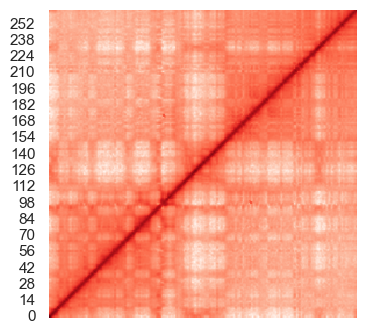

In [13]:
chromosome = "11"
resolution = 500000

model.read_data(paht_to_file, chromosome, resolution)
model.draw_contact_matrix()

Found 7 TADs


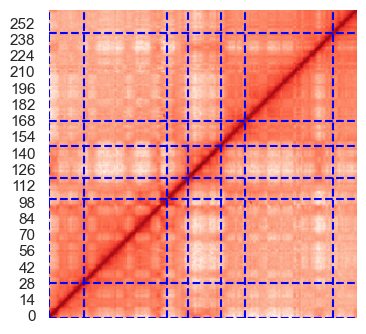

In [14]:
max_num_of_tads = 7
min_tad_size = math.floor(len(model.data)/15)
max_r = math.floor(len(model.data)/2)

boundries = model.get_tad_boundaries(max_num_of_tads, min_tad_size, max_r)
model.draw_contact_matrix_with_boundries(boundries)

## Chromosome 11, resolution 100.000

HiC version:  7
Number of rows: 604977
Number of unique x and y values: 1316, 1316
Mean interactions per fragment 12.423871180692371
Median of interactions per fragment 3.0443221075147715


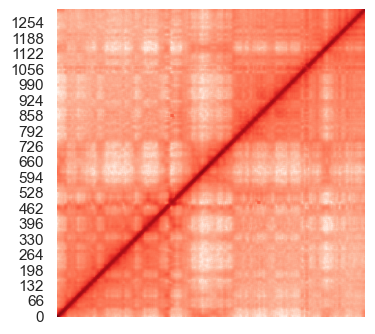

In [10]:
chromosome = "11"
resolution = 100000

model.read_data(paht_to_file, chromosome, resolution)
model.draw_contact_matrix()

Found 7 TADs


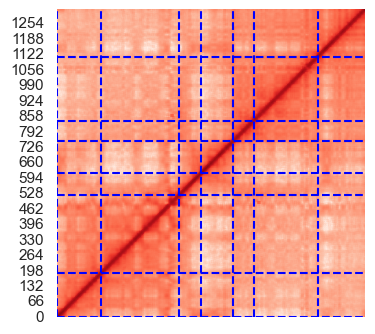

In [12]:
max_num_of_tads = 7
min_tad_size = math.floor(len(model.data)/15)
max_r = math.floor(len(model.data)/2)

boundries = model.get_tad_boundaries(max_num_of_tads, min_tad_size, max_r)
model.draw_contact_matrix_with_boundries(boundries)